In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier


df = pd.read_csv('german_credit_data.csv')


In [87]:
# Exploratory Data Analysis Before Preprocessing
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [88]:
# Check data information
df.info()

# 각 feature와 타입 확인

# Job의 경우, 1/2/3/4 개념의 카테고리 값이므로 타입 변경
df['Job'] = df['Job'].astype(object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
Unnamed: 0          1000 non-null int64
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(5), object(6)
memory usage: 86.0+ KB


In [89]:
# Unnamed: 0의 경우, 각 record의 번호를 의미. 데이터 예측에 쓸모 없으므로 삭제
df.drop(df.columns[0], axis=1, inplace=True)

# describe
df.describe()

,Age,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000
std,11.375469,2822.736876,12.058814
min,19.000000,250.000000,4.000000
25%,27.000000,1365.500000,12.000000
50%,33.000000,2319.500000,18.000000
75%,42.000000,3972.250000,24.000000
max,75.000000,18424.000000,72.000000


In [90]:
# missing data
missing = df.isnull().sum()
print(missing) # print count of missing value

# missing 값 비율 확인
missing = missing.reset_index()
missing.columns = ['column', 'count'] # initialize the column name
missing['ratio'] = missing['count']/df.shape[0] # add the column

# missing 값이 있는 속성만 print
print(missing.loc[missing['ratio'] != 0])

# missing 양이 많지 않음을 확인

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64
             column  count  ratio
4   Saving accounts    183  0.183
5  Checking account    394  0.394


In [91]:
# missing data 삭제
df.dropna(inplace=True)
print(df.isnull().sum()) # print count of missing value

# 데이터 개수
print(len(df))


Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64
522


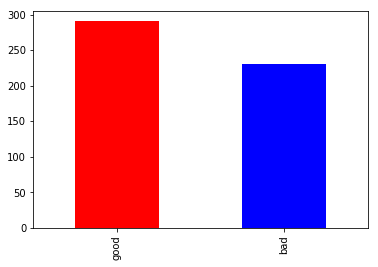

In [92]:
# Check the target variable
df['Risk'].value_counts().plot(kind = 'bar', color=['red', 'blue'])
plt.show()
# 어느정도 나눠져 있는 모습을 확인


['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


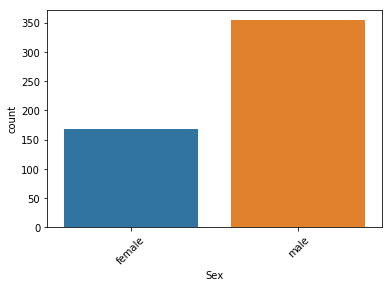

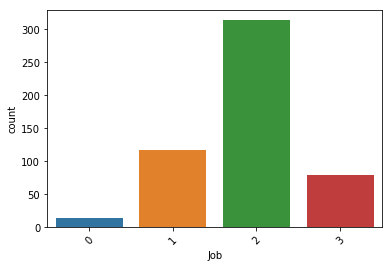

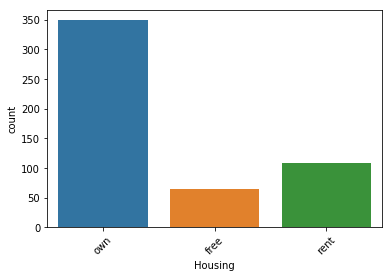

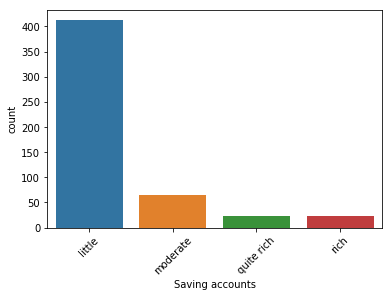

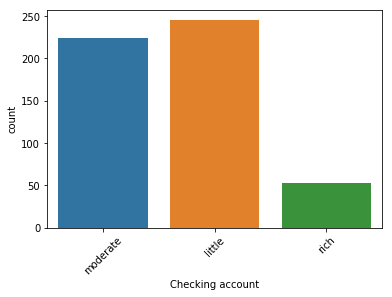

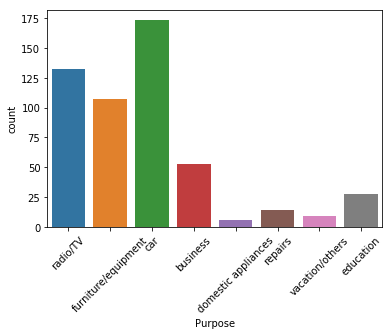

In [93]:
# Check the categorical data
category_feature = [col for col in df.columns if df[col].dtypes == 'object']
print(category_feature)

for col in category_feature:
    if col == 'Risk':
        continue
    sns.countplot(x=col,data=df)
    plt.xticks(rotation=45)
    plt.show()

# 많은 카테고리 데이터들이 어느정도 골고루 나뉘어져 있고,
# 하나의 값으로 수렴하거나, 다 다른 값을 가지지 않는 것을 확인

['Age', 'Credit amount', 'Duration']


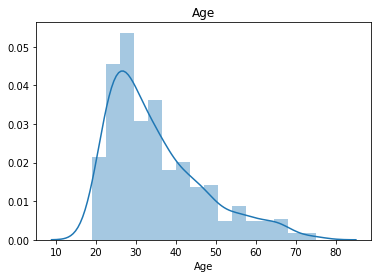

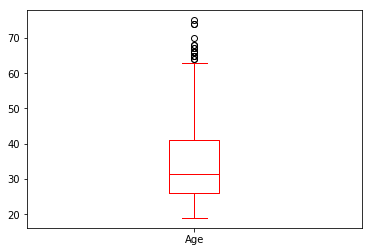

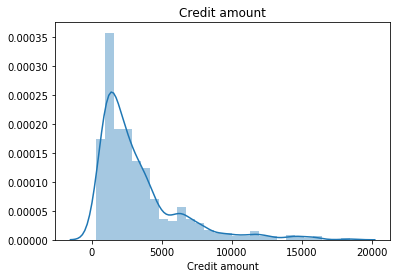

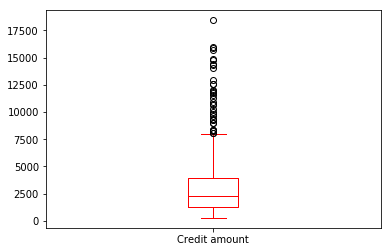

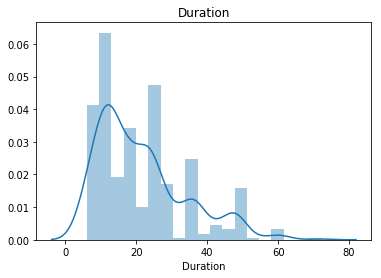

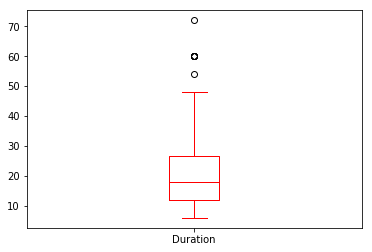

In [94]:
# Check the numerical data
numerical_feature = [col for col in df.columns if df[col].dtypes == 'int64']
print(numerical_feature)

def dist_box(df, feature_list):
    for col in feature_list:
        sns.distplot(df.loc[df[col].notnull(), col])
        plt.title(col)
        plt.show()

        df[col].plot(kind='box', color='red')
        plt.show()
        
dist_box(df, numerical_feature)
# 수 데이터들의 분포가 어느정도 한 쪽으로 쏠려져 있음을 확인
# Outlier의 존재도 있다는 것을 확인

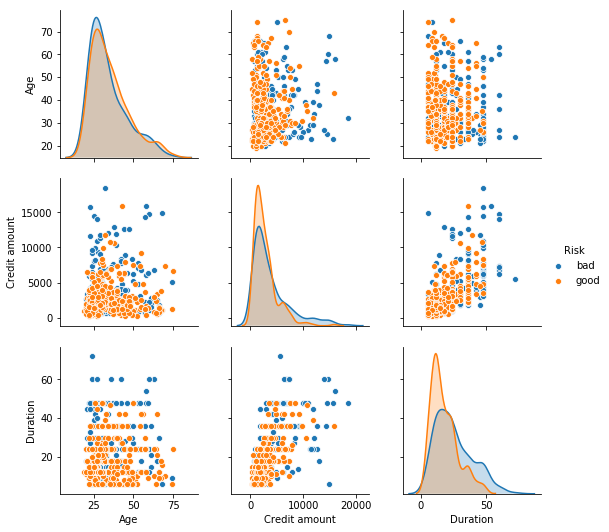

In [95]:
# 수 데이터관 관계를 그래프로 나타내 봄.
sns.pairplot(df[list(numerical_feature) + ['Risk']], hue = 'Risk'
                , x_vars = numerical_feature, y_vars = numerical_feature)

plt.show()

# 그래프 해석에 있어서 특별하게 해석할 수 있는 요인을 볼 수 없었다.

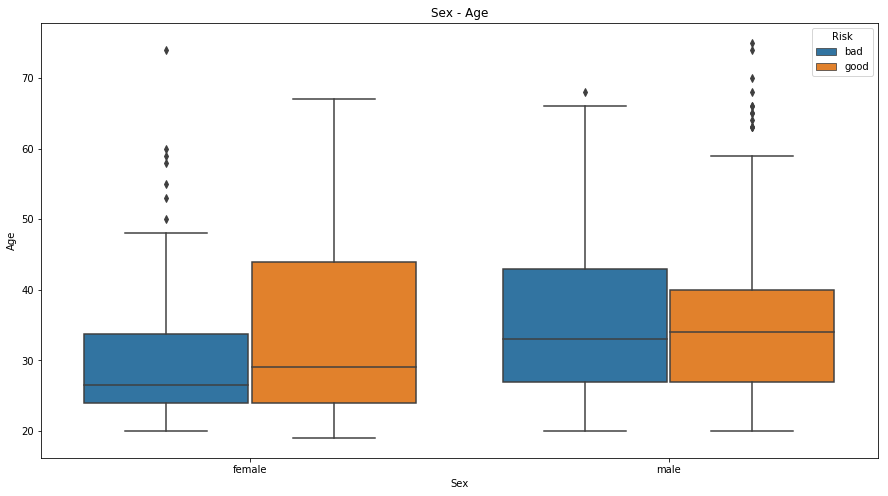

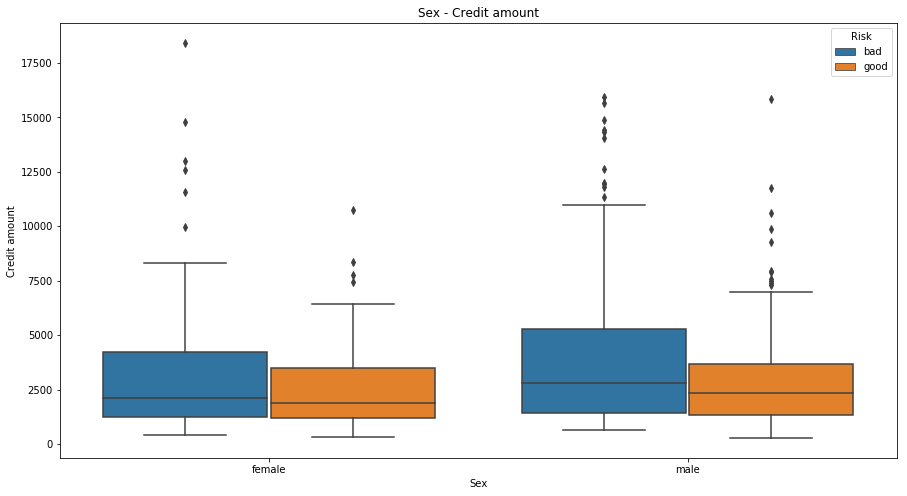

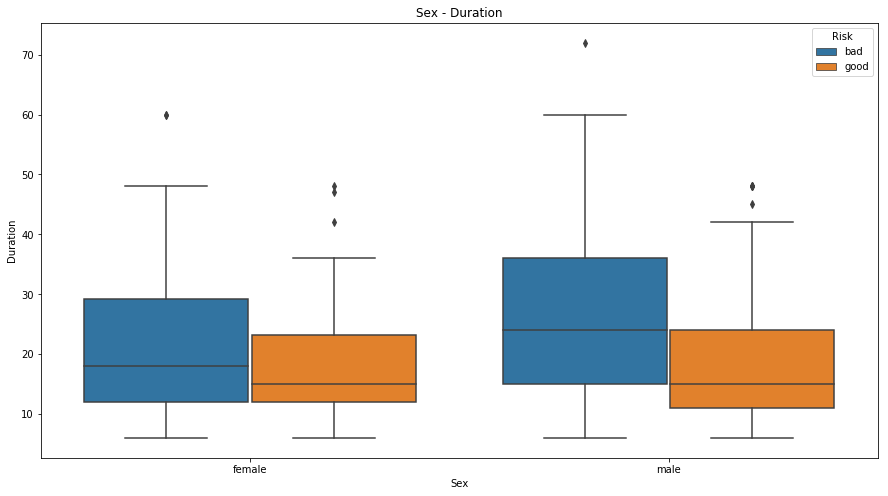

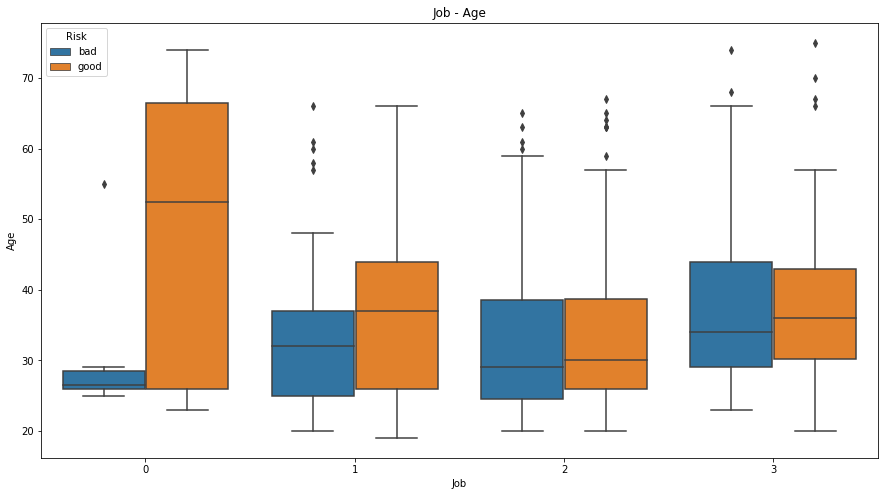

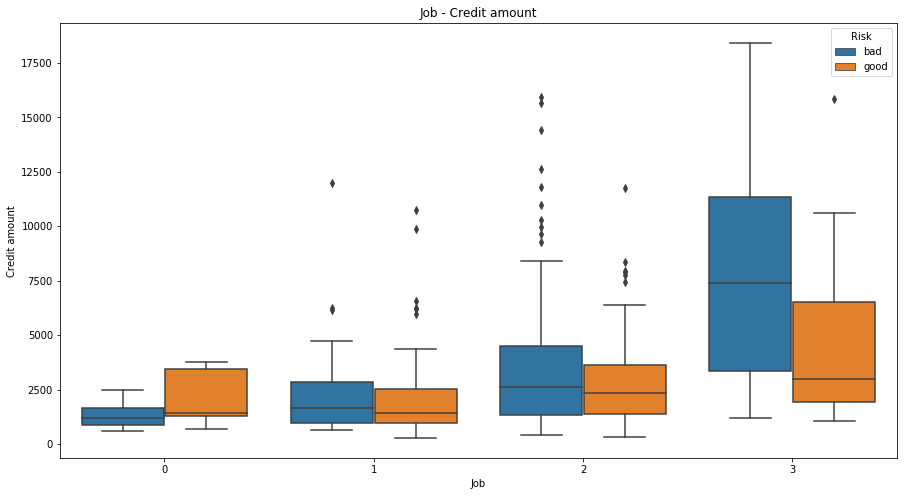

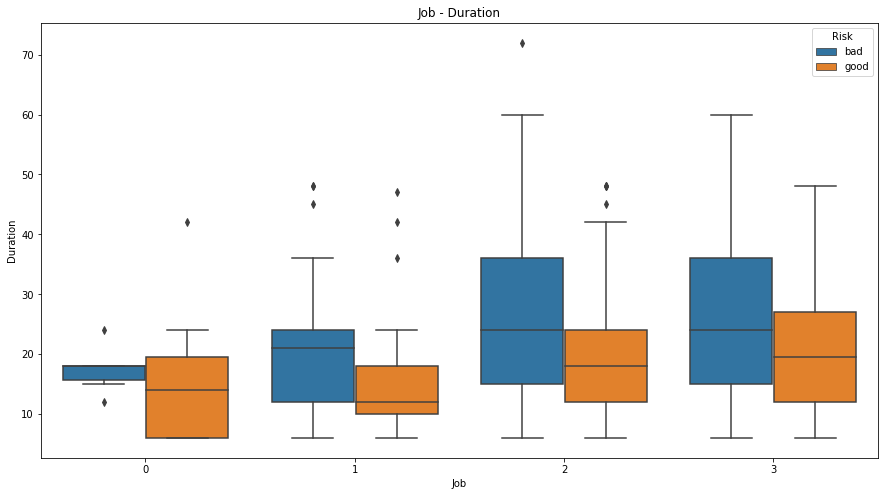

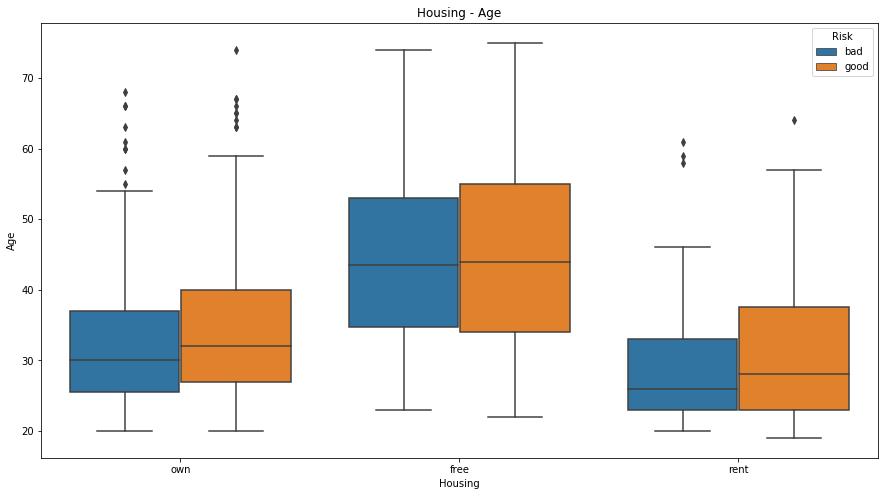

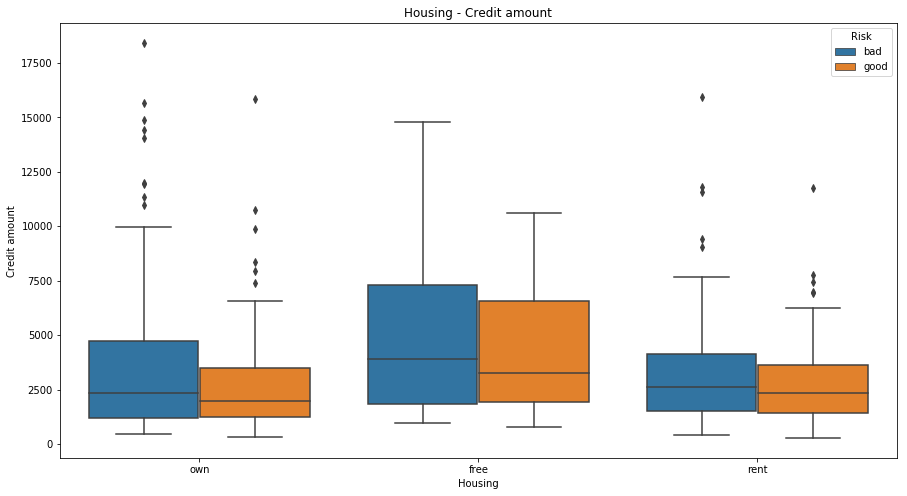

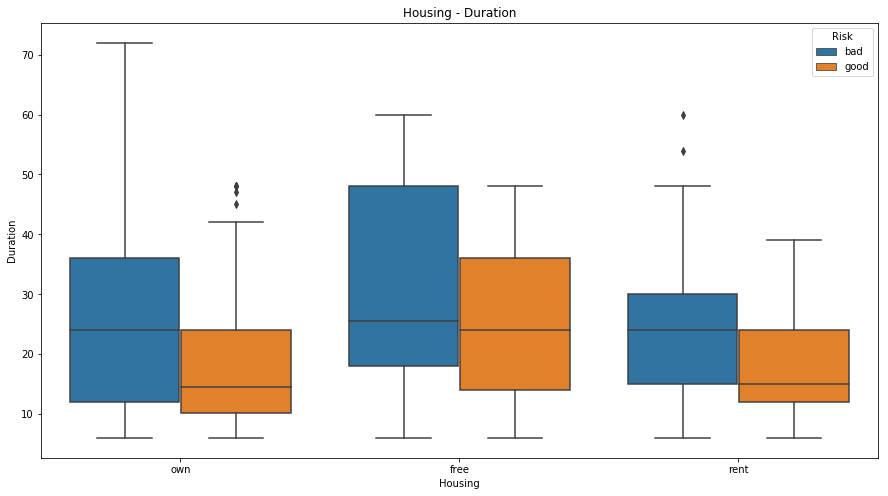

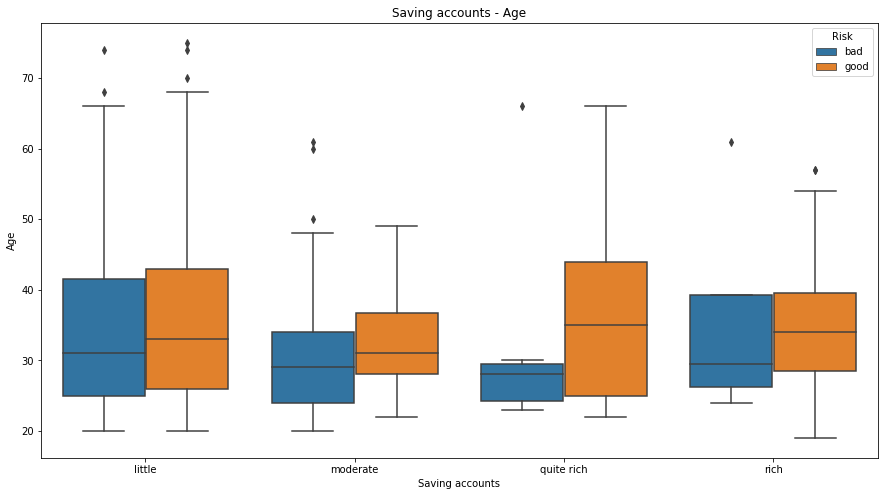

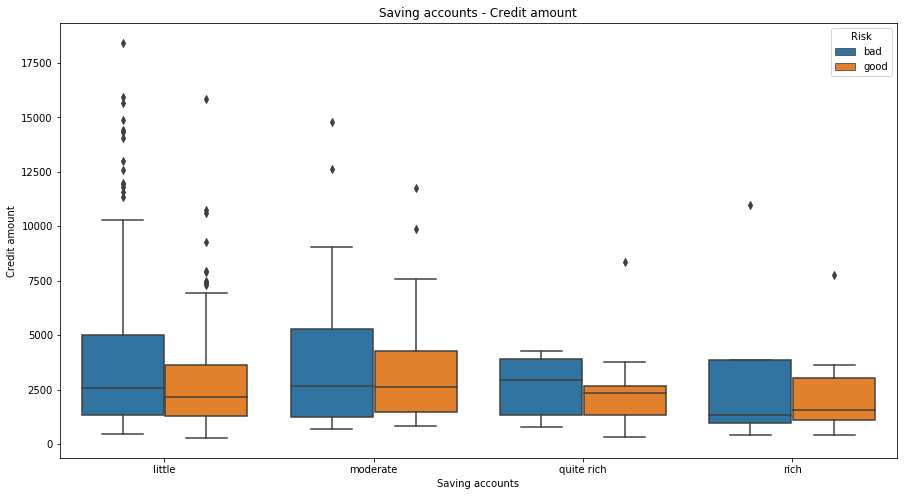

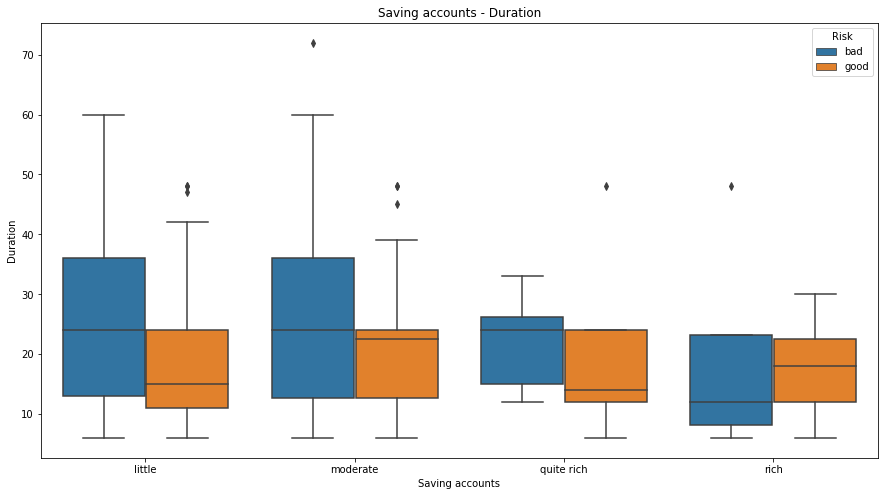

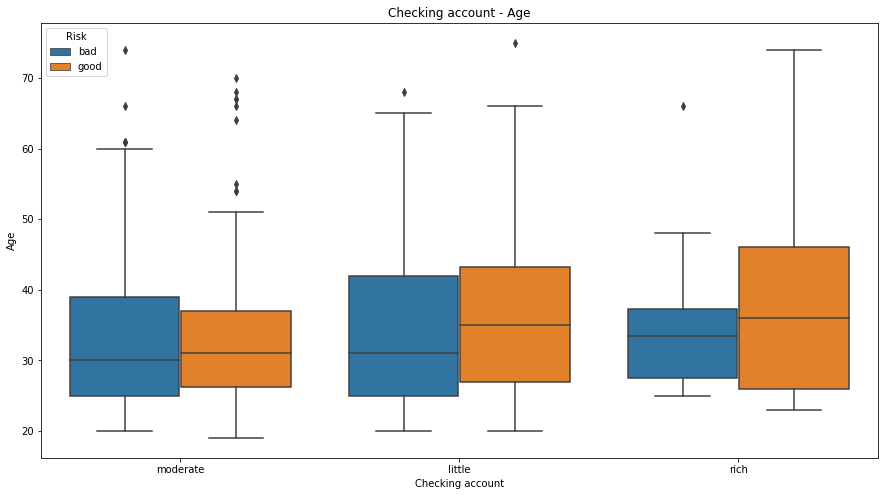

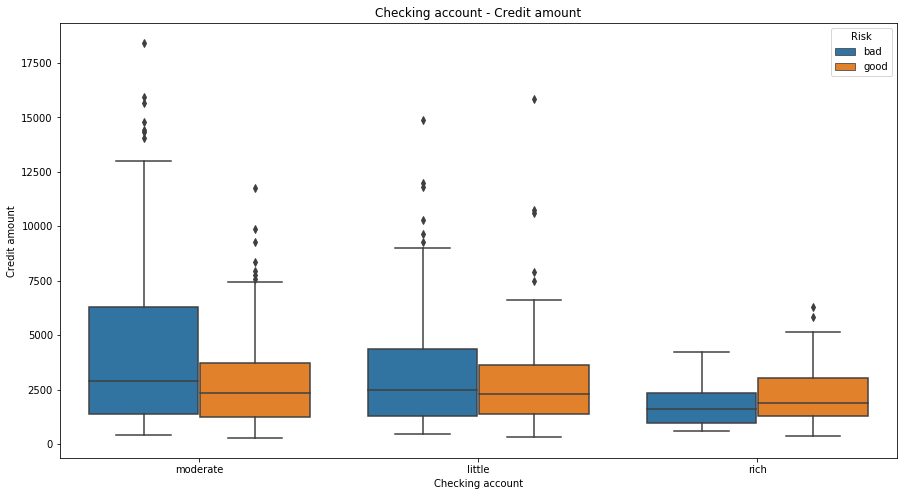

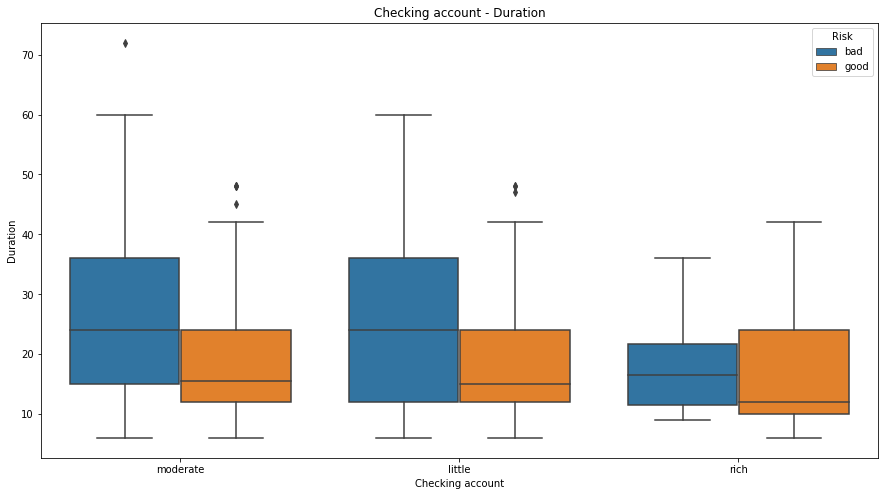

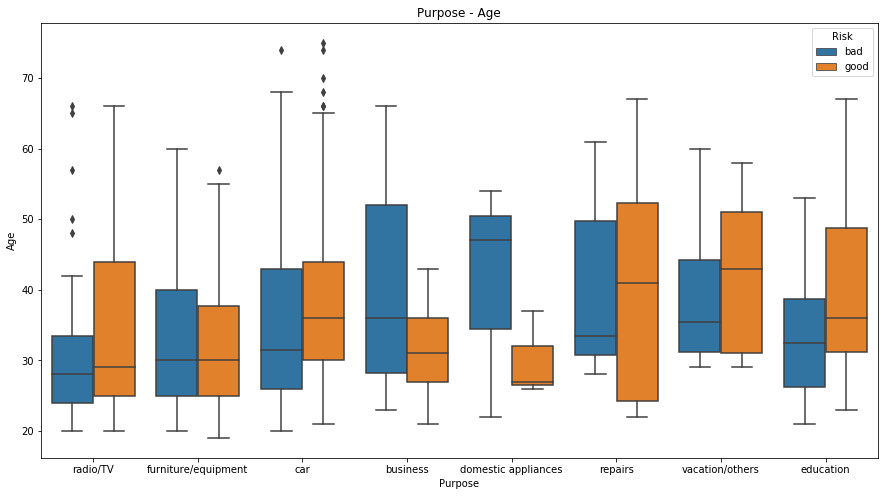

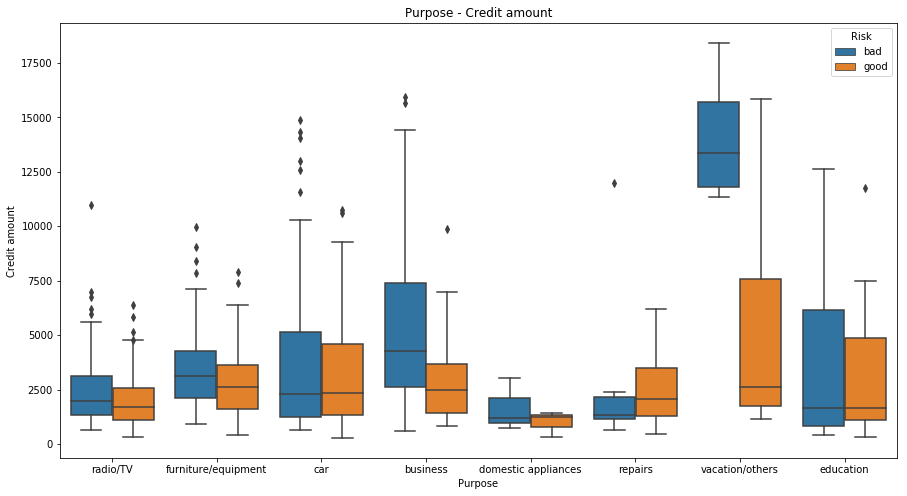

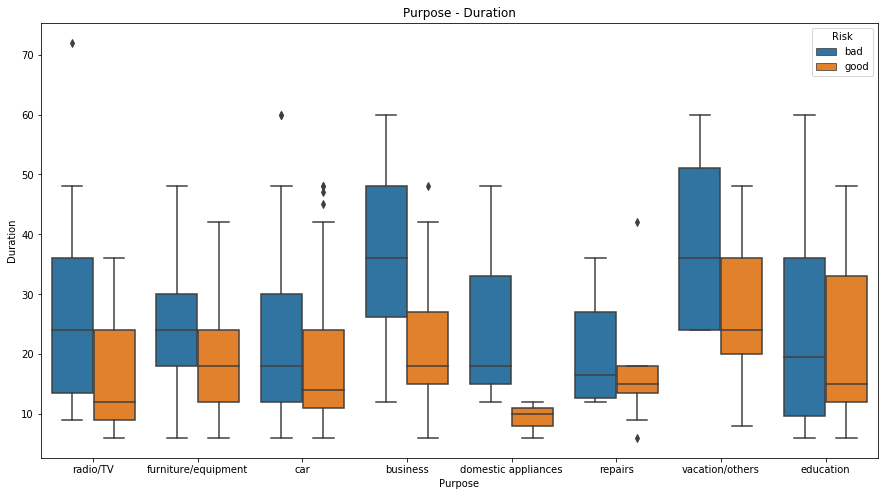

In [96]:
# check the relationship with categorical data and numerical data

def comp_cat_num(ca, nu):
    for col in ca:
        if col == 'Risk':
            continue
        for col2 in nu:
            plt.figure(figsize = (15, 8))
            sns.boxplot(x=col, y = col2, hue = 'Risk', data = df)
            plt.title('{} - {}' .format(col, col2))
            plt.show()


comp_cat_num(category_feature, numerical_feature)


Age 15.0
Credit amount 2675.0
Duration 12.0


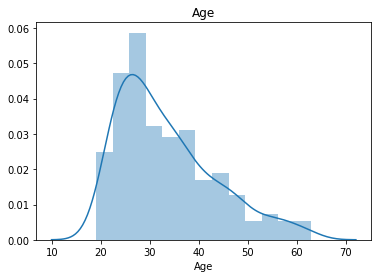

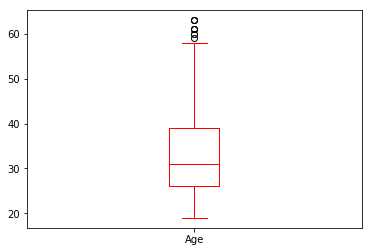

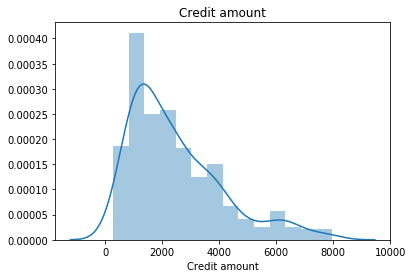

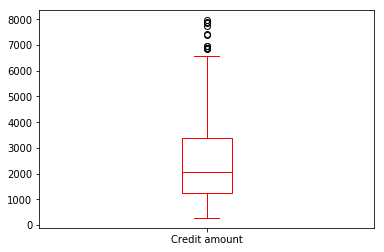

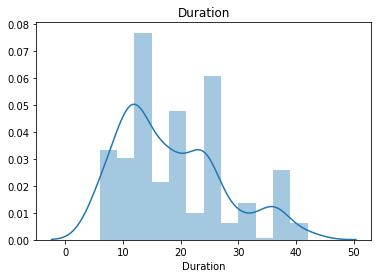

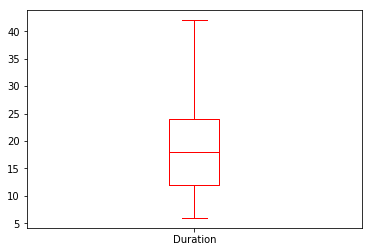

In [97]:
# remove the outlier of numerical data using IQR
for col in numerical_feature:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    print(col, IQR)
    df =  df[(df[col] >= (Q1 - 1.5 * IQR))
            & (df[col] <= (Q3 + 1.5 * IQR))]
    
    # df[col] = np.log1p(df[col]) # skewed data 처리
    # 안하는게 정확도가 제일 높음.    


dist_box(df, numerical_feature)


In [98]:
# 카테고리얼 데이터 처리
le = preprocessing.LabelEncoder()
for col in category_feature:
    df[[col]] = le.fit_transform(df[[col]])

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

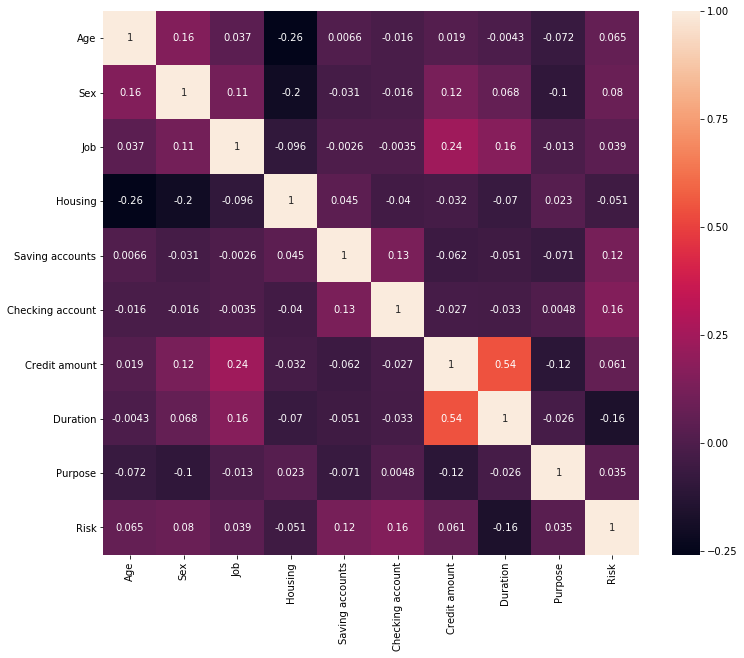

In [99]:

# correlation
# calculate the correlation matrix
corr = df.corr()
# adjust matrix size to (12, 10)
plt.subplots( figsize =( 12 , 10 ) )
# plot the correlation heatmap
sns.heatmap(corr,
        annot=True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Risk와 correlation 낮은 것 제거했더니, 정확률 낮아짐
# Checking account, duration과 제일 연관관계가 있다.

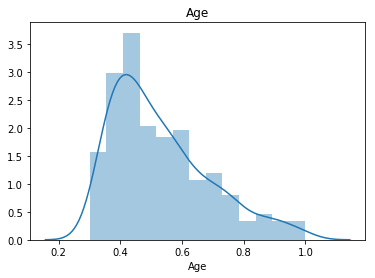

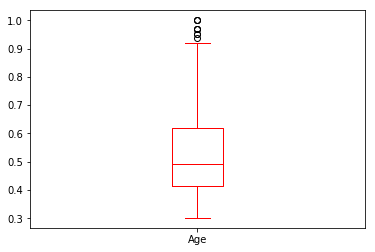

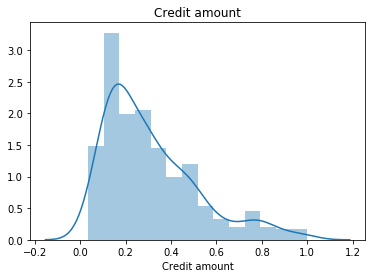

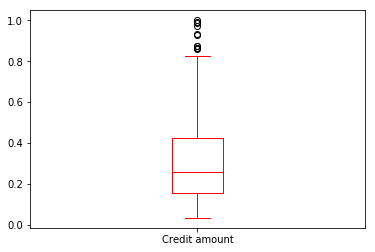

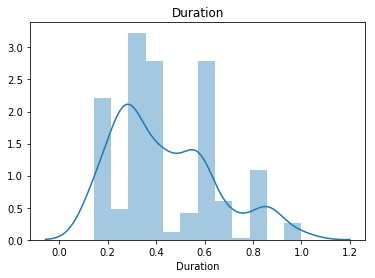

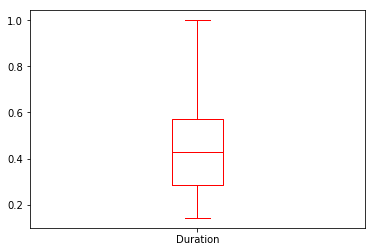

In [100]:

# X and y variables
X = df.drop(['Risk'], axis = 1)
y = df['Risk']

# re-scale

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
#scaler = RobustScaler()
#scaler = MinMaxScaler()
scaler = MaxAbsScaler()
#scaler = StandardScaler()
# 제일 정확률 높은 MaxAbsScaler 사용
X[numerical_feature] = scaler.fit_transform(X[numerical_feature])

# numerical data 분포 재확인
dist_box(X, numerical_feature)

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state = 42)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

LR: 0.825430 (0.111897)
LDA: 0.791880 (0.094928)
KNN: 0.765423 (0.103879)
CART: 0.673728 (0.119165)
NB: 0.632249 (0.124996)
RF: 0.636700 (0.092171)


C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: Future

SVM: 0.924394 (0.100014)
XGB: 0.725192 (0.110128)


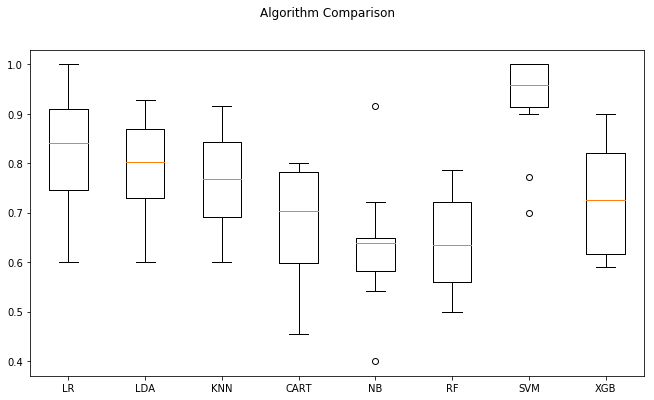

In [101]:
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGB', XGBClassifier()))

# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()